In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation as exclude
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
base_path = "/content/drive/MyDrive/Framing Bias Detection in News using Deep Learning"

In [ ]:
data1 = pd.read_csv(f'{base_path}/Sentiment_dataset.csv')
data2 = pd.read_csv(f'{base_path}/all-data.csv', encoding='ISO-8859-1', header=None, names=['label', 'text'])

In [ ]:
data2.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
def change_labels(label):
    if label == 1:
      return "positive"
    else:
      return "negative"
data1['label'] = data1['sentiment'].apply(change_labels)

In [ ]:
data = pd.concat([data1[['text', 'label']], data2[['text', 'label']]], ignore_index=True)

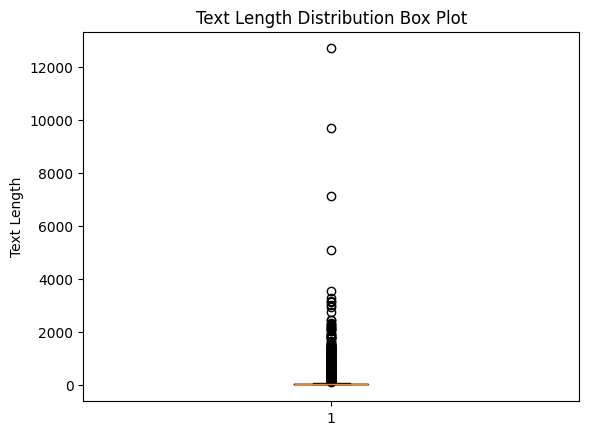

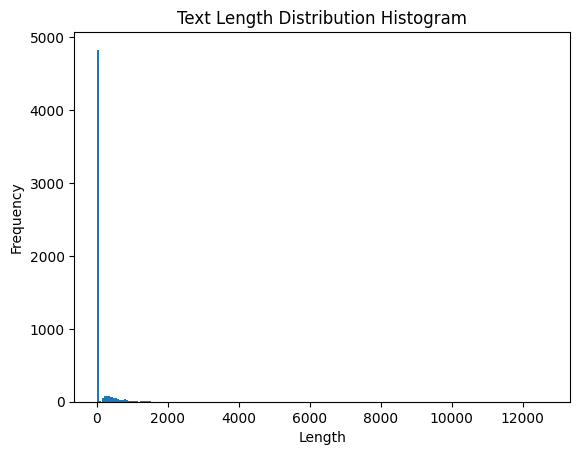

In [ ]:
import matplotlib.pyplot as plt
lengths = [len(text.split()) for text in data['text']]
plt.boxplot(lengths)
plt.ylabel("Text Length")
plt.title("Text Length Distribution Box Plot")
plt.show()

plt.hist(lengths, bins=250)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution Histogram")
plt.show()

In [ ]:
data['label'].value_counts()

,count
label,
neutral,2879
positive,2111
negative,704


In [ ]:
X = data['text']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

In [ ]:
label_encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    embeddings_index = {}

    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  # Word
            vector = np.asarray(values[1:], dtype="float32")  # Embedding vector
            embeddings_index[word] = vector

    # Create embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Words found in GloVe

    return embedding_matrix

In [ ]:
# HELPER FUNCTIONS
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import string

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
exclude = string.punctuation
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  new_text = []
  for word in text.split():
    if word not in stop_words:
      new_text.append(word)
  return " ".join(new_text)

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

def remove_urls(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def clean_text(X, max_sequence_length=100):
  """
    Text cleaner: It does stemming, tokenization and embedding generation of the data
    Args:
      X (array(str)): Articles
      y (array(int)): Categories of articles
      max_sequence_length (int): Max length of sequence

    Returns:
      X_resampled, y_resampled, embedding_matrix, tokenizer
  """

  lower_text_X = [text.lower() for text in X]
  lower_text_X = [remove_urls(text) for text in lower_text_X]
  lower_text_X = [remove_numbers(text) for text in lower_text_X]

  no_punc_text_X = [remove_punc(text) for text in lower_text_X]

  stop_word_clean_text_X = [remove_stopwords(word) for word in no_punc_text_X]

  stemmer = PorterStemmer()
  stemmed_text = [" ".join([stemmer.stem(word) for word in sentence.split()]) for sentence in stop_word_clean_text_X]

  # lemmatizer = WordNetLemmatizer()
  # stemmed_text = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in stemmed_text]

  tokenizer = Tokenizer(
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\tâ€\n',
      oov_token="<OOV>",
      lower=True,
      num_words=30000)
  tokenizer.fit_on_texts(stemmed_text)

  sequences = tokenizer.texts_to_sequences(stemmed_text)
  padded_sequences = pad_sequences(sequences, padding= "post",maxlen=max_sequence_length)

  word_index = tokenizer.word_index
  glove_path = "/content/drive/MyDrive/Major Project/glove.6B.100d.txt"
  embedding_matrix = load_glove_embeddings(glove_path=glove_path, word_index=word_index)

  return padded_sequences, embedding_matrix, tokenizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_padded, embedding_matrix, tokenizer= clean_text(X, max_sequence_length=200)

In [ ]:
import os
try:
    with open(f"{base_path}/tests/current_model_count.txt", "r") as file:
        test_count = int(file.read())
except FileNotFoundError:
        test_count = 0
test_count += 1

In [ ]:
import pickle

os.makedirs(f"{base_path}/tests/test_{test_count}", exist_ok=True)

# Save padded sequences
np.save(f"{base_path}/tests/test_{test_count}/X_padded.npy", X_padded)

# Save embedding matrix
np.save(f"{base_path}/tests/test_{test_count}/embedding_matrix.npy", embedding_matrix)

# Save tokenizer
with open(f"{base_path}/tests/test_{test_count}/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
# MODEL MAKER FUNCTIONS
# MAX_FEATURES = 39913
# LSTM MODEL FUNCTION
# MAX_FEATURES = 46042
# MAX_FEATURES = 37909
MAX_FEATURES = 28970
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def model_maker_LSTM(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # LSTM Layer
  model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  model.add(Bidirectional(LSTM(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# GRU MODEL FUNCTION
def model_maker_GRU(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # GRU Layer
  model.add(Bidirectional(GRU(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  model.add(Bidirectional(GRU(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# HYBRID MODEL FUNCTION
def model_maker_hybrid(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # LSTM Layer
  model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  # GRU Layer
  model.add(Bidirectional(GRU(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def create_models(embedding_matrix):
  models = {}
  models["model_lstm"] = model_maker_LSTM(embedding_matrix=embedding_matrix)
  models["model_gru"] = model_maker_GRU(embedding_matrix=embedding_matrix)
  models["model_hybrid"] = model_maker_hybrid(embedding_matrix=embedding_matrix)
  return models

In [ ]:
models = create_models(embedding_matrix)

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def create_split_and_resampling(X, y):
  print("Creating Split...")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  print("Resampling Training Split...")
  ros = RandomOverSampler(random_state=42)
  X_res, y_res = ros.fit_resample(X_train, y_train)

  unique, counts = np.unique(y_res, return_counts=True)
  y_res = to_categorical(y_res, num_classes=3)
  print(f"Values resampled by {counts}")
  print("Split Created!")
  return X_res, y_res, X_test, y_test


In [ ]:
X_train, y_train, X_test, y_test = create_split_and_resampling(X_padded, y)

Creating Split...
Resampling Training Split...
Values resampled by [2303 2303 2303]
Split Created!


In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y),
#     y=y
# )

# class_weights_dict = dict(enumerate(class_weights))


def model_training(models, early_stopping, train_model="all", class_weights_dict=None):

  history = {}
  for model_name, model in models.items():
    if model_name in train_model or train_model == "all":
      print("="*50)
      print(f"Training {model_name}...")
      history[model_name] = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        class_weight = class_weights_dict,
        callbacks=[early_stopping],
      )
      print(f"{model_name} trained successfully!")
  print("MODEL(s) TRAINED SUCCESSFULLY")

  return history

In [ ]:
history = model_training(models, early_stopping, train_model="all")

Training model_lstm...
Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.4998 - loss: 1.0197 - val_accuracy: 0.5253 - val_loss: 0.9312
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6552 - loss: 0.7951 - val_accuracy: 0.5507 - val_loss: 1.1158
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7539 - loss: 0.6012 - val_accuracy: 0.8423 - val_loss: 0.4389
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8435 - loss: 0.4475 - val_accuracy: 0.9052 - val_loss: 0.2315
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8976 - loss: 0.3005 - val_accuracy: 0.9363 - val_loss: 0.1470
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9330 - loss: 0.2093 - val_accuracy: 0.9616 - val_loss: 0.1221
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9416 - loss: 0.1908 - val_accuracy: 0.9660 - val_loss: 0.1305
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode
import pickle

def pred_pipeline(models, X_test, y):
    predictions = {}
    for model_name, model in models.items():
      print(f"Evaluating {model_name}...")
      y_pred = model.predict(X_test)
      predictions[model_name] = y_pred
      y_pred_labels = np.argmax(y_pred, axis=1)
      print(classification_report(y, y_pred_labels))
      print("="*25)

    ensemble_pred = {}
    # SOFT VOTING
    y_pred_soft_voting = np.mean([predictions[model_name] for model_name in predictions], axis=0)
    y_pred_soft_voting_labels = np.argmax(y_pred_soft_voting, axis=1)
    ensemble_pred['soft_voting'] = y_pred_soft_voting_labels

    # HARD VOTNG
    y_pred_hard_voting = np.vstack([np.argmax(predictions[model_name], axis=1) for model_name in predictions])
    y_pred_hard_voting_labels = mode(y_pred_hard_voting, axis=0)[0].flatten()
    ensemble_pred['hard_voting'] = y_pred_hard_voting_labels

    print(f"SOFT VOTING: {classification_report(y, y_pred_soft_voting_labels)}")
    print(f"HARD VOTING: {classification_report(y, y_pred_hard_voting_labels)}")


    return predictions, ensemble_pred

In [ ]:
# SCRIPT FOR SAVING IMPORTANT MODEL
def save_models(models):
    os.makedirs(f"{base_path}/tests/test_{test_count}/models", exist_ok=True)
    for model_name, model in models.items():
        model.save(f"{base_path}/tests/test_{test_count}/models/model_{model_name}.keras")

with open(f"{base_path}/current_model_count.txt", "w") as file:
    file.write(str(test_count))


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(predictions, ensemble_pred, y_test, test_count, save_fig=True):
    cm_dir = os.path.join(base_path, "tests", f"test_{test_count}", "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)

    for model, prediction in predictions.items():
        # print(f"Confusion Matrix: {model}")
        y_pred_labels = np.argmax(prediction, axis=1)
        cm = confusion_matrix(y_test, y_pred_labels)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{model} Confusion Matrix")
        plt.tight_layout()
        if save_fig:
          plt.savefig(os.path.join(cm_dir, f"{model}_cm.png"))
        plt.show()
        plt.close()

    for method, prediction in ensemble_pred.items():
        # print(f"Confusion Matrix: {method}")
        cm = confusion_matrix(y_test, prediction)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{method} Confusion Matrix")
        plt.tight_layout()
        if save_fig :
          plt.savefig(os.path.join(cm_dir, f"{method}_cm.png"))
        plt.show()
        plt.close()

def print_metrics(predictions, ensemble_pred, y_test, test_count):
    metrics_path = os.path.join(base_path, "tests", f"test_{test_count}", "metrics.txt")
    os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

    with open(metrics_path, "w") as f:
        for model, prediction in predictions.items():
            y_pred_labels = np.argmax(prediction, axis=1)
            report = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_)
            print(f"Metrics: {model}")
            print("=" * 25)
            print(report)
            f.write(f"Metrics: {model}\n")
            f.write("=" * 25 + "\n")
            f.write(report + "\n\n")

        for method, prediction in ensemble_pred.items():
            report = classification_report(y_test, prediction, target_names=label_encoder.classes_)
            print(f"Metrics: {method}")
            print("=" * 25)
            print(report)
            f.write(f"Metrics: {method}\n")
            f.write("=" * 25 + "\n")
            f.write(report + "\n\n")

In [ ]:
save_models(models)

In [ ]:
prediction, ensemble_pred = pred_pipeline(models, X_test, y_test)

Evaluating model_lstm...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       141
           1       0.81      0.78      0.80       576
           2       0.69      0.73      0.71       422

    accuracy                           0.74      1139
   macro avg       0.71      0.71      0.71      1139
weighted avg       0.74      0.74      0.74      1139

Evaluating model_gru...
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       141
           1       0.84      0.78      0.81       576
           2       0.71      0.78      0.75       422

    accuracy                           0.76      1139
   macro avg       0.73      0.73      0.73      1139
weighted avg       0.77      0.76      0.76      1139

Evaluating model_hybrid...
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
              precision    recall  f1-scor

In [ ]:
print_metrics(predictions=prediction, ensemble_pred=ensemble_pred, y_test=y_test, test_count=test_count)

Metrics: model_lstm
              precision    recall  f1-score   support

    negative       0.64      0.61      0.62       141
     neutral       0.81      0.78      0.80       576
    positive       0.69      0.73      0.71       422

    accuracy                           0.74      1139
   macro avg       0.71      0.71      0.71      1139
weighted avg       0.74      0.74      0.74      1139

Metrics: model_gru
              precision    recall  f1-score   support

    negative       0.62      0.64      0.63       141
     neutral       0.84      0.78      0.81       576
    positive       0.71      0.78      0.75       422

    accuracy                           0.76      1139
   macro avg       0.73      0.73      0.73      1139
weighted avg       0.77      0.76      0.76      1139

Metrics: model_hybrid
              precision    recall  f1-score   support

    negative       0.61      0.61      0.61       141
     neutral       0.81      0.80      0.81       576
    positive  

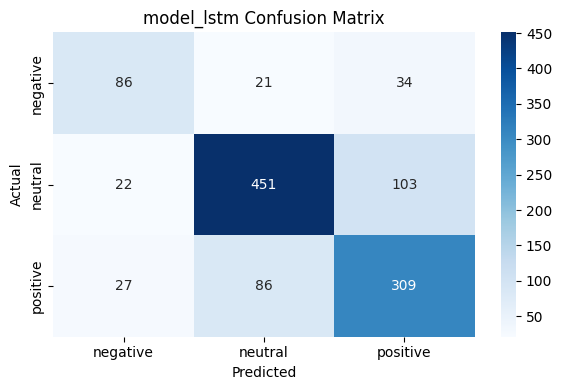

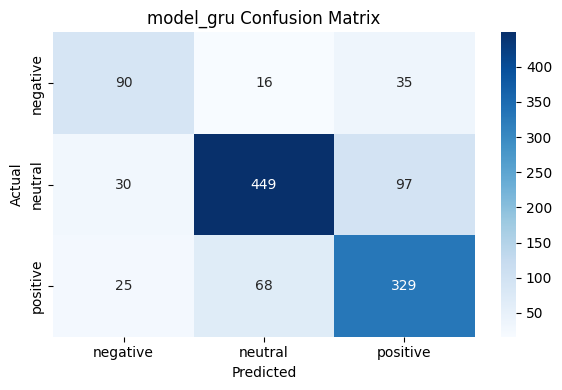

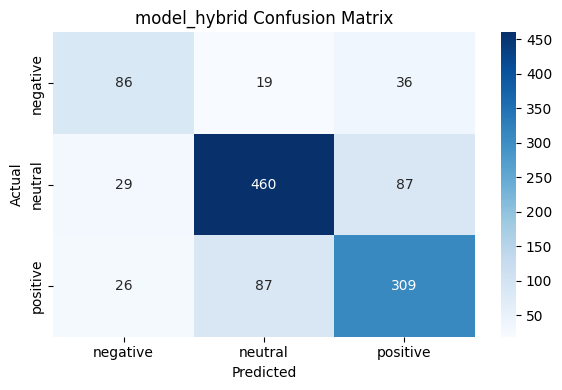

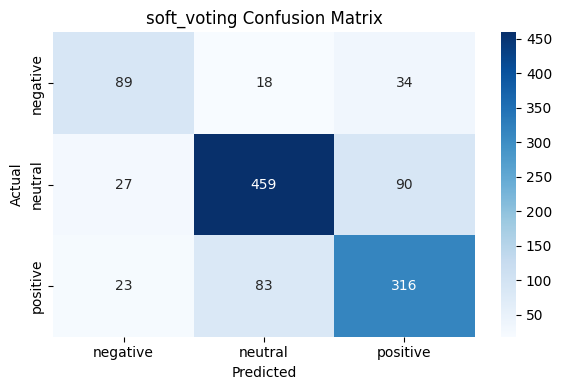

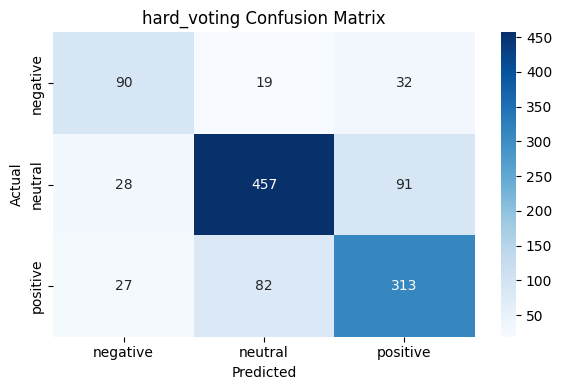

In [ ]:
print_confusion_matrix(predictions=prediction, ensemble_pred=ensemble_pred, y_test=y_test, test_count=test_count)

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_curve(y_true, y_pred_prob, n_classes=3, title="ROC Curve - Soft Voting Ensemble", save_fig=True):

    # Class labels for your specific case
    classes = label_encoder.classes_

    # Step 1: Binarize the labels
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Step 2: Compute ROC and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', label=f"Macro Avg (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()


    if save_fig:
        metric_dir = os.path.join(base_path, f"tests/test_{test_count}/metric_curves")
        os.makedirs(metric_dir, exist_ok=True)

        plt.savefig(os.path.join(metric_dir, f"{title}_roc_curve.png"))
        print(f"ROC curve saved to {metric_dir}/roc_curve.png")

    plt.show()

ROC curve saved to /content/drive/MyDrive/Framing Bias Detection in News using Deep Learning/tests/test_1/metric_curves/roc_curve.png


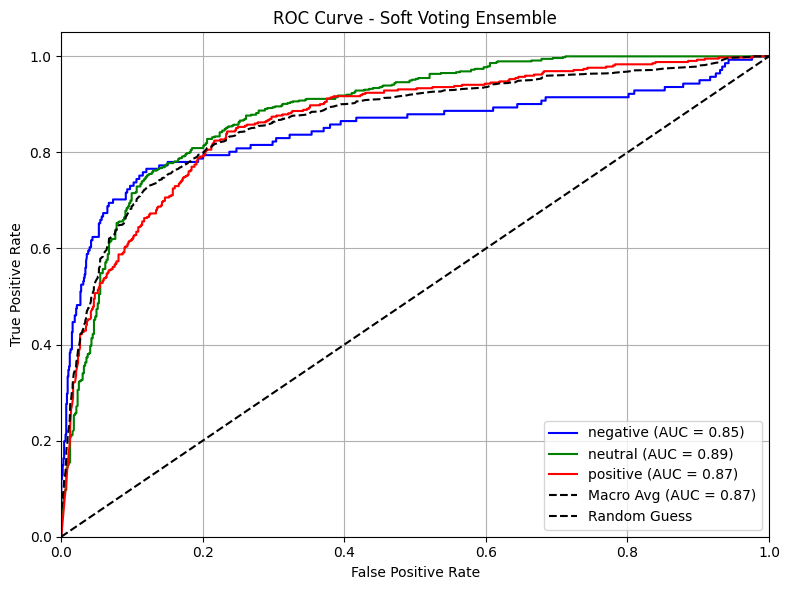

In [ ]:
y_pred_soft_probs = np.mean([prediction[m] for m in prediction], axis=0)

plot_roc_curve(y_true=y_test, y_pred_prob=y_pred_soft_probs)

ROC curve saved to /content/drive/MyDrive/Framing Bias Detection in News using Deep Learning/tests/test_1/metric_curves/roc_curve.png


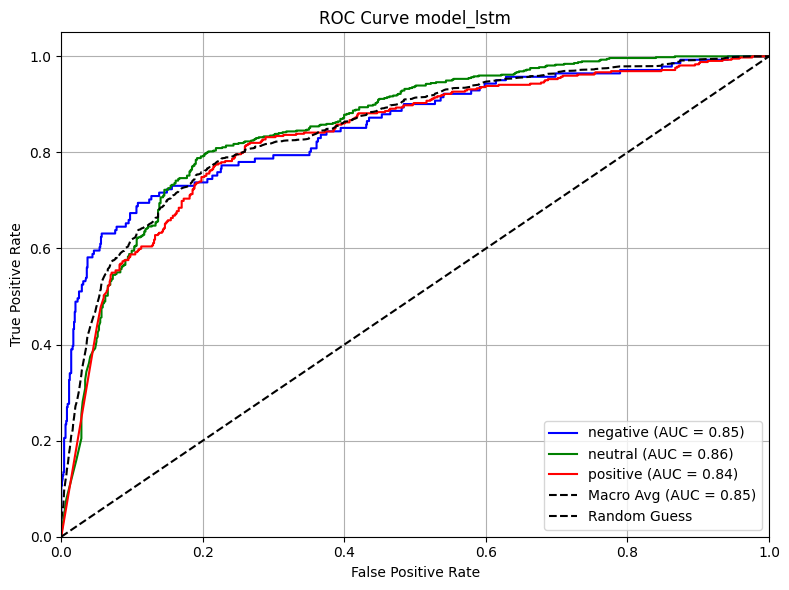

ROC curve saved to /content/drive/MyDrive/Framing Bias Detection in News using Deep Learning/tests/test_1/metric_curves/roc_curve.png


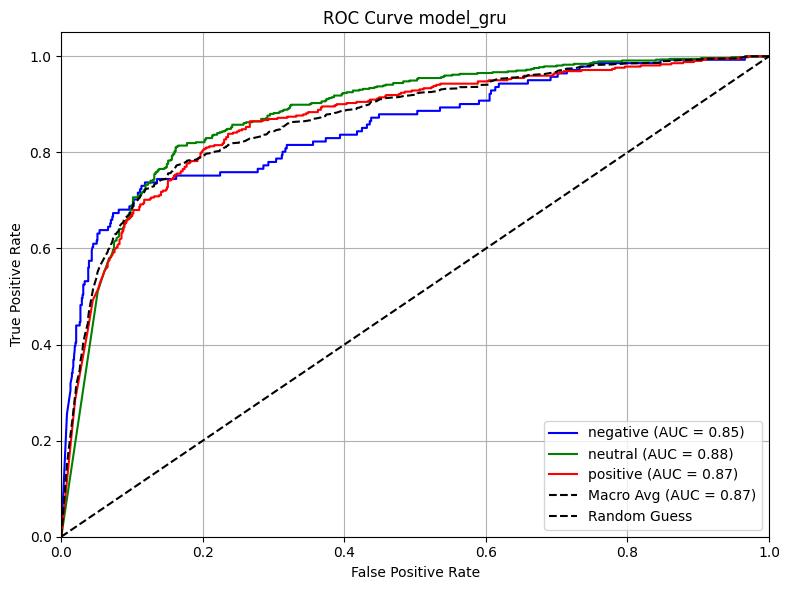

ROC curve saved to /content/drive/MyDrive/Framing Bias Detection in News using Deep Learning/tests/test_1/metric_curves/roc_curve.png


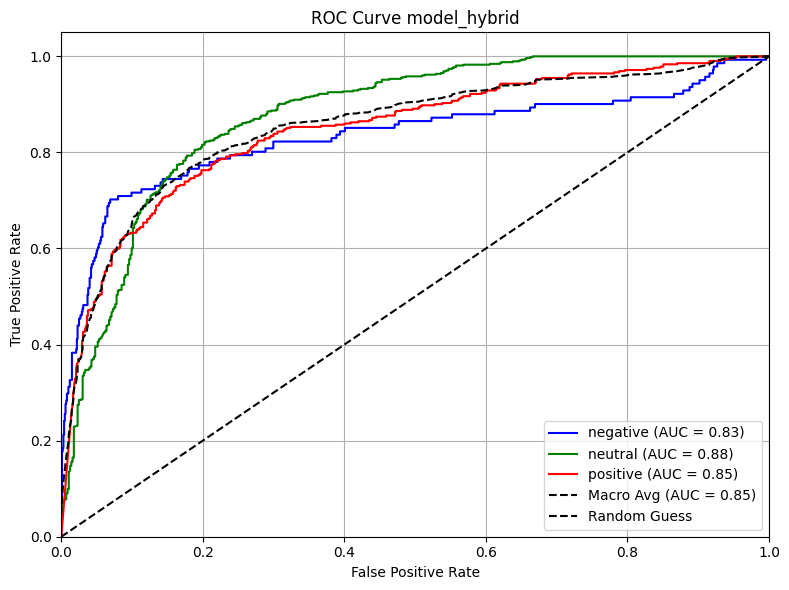

In [ ]:
for model_name, predict in prediction.items():
  plot_roc_curve(y_test, predict, title=f"ROC Curve {model_name}")

In [ ]:
print(f"Soft Voting acc: {accuracy_score(ensemble_pred['soft_voting'], y_test)}")
print(f"Hard Voting acc: {accuracy_score(ensemble_pred['hard_voting'], y_test)}")

Soft Voting acc: 0.7585601404741001
Hard Voting acc: 0.7550482879719052


In [ ]:
INFO_PATH = os.path.join(base_path, f"tests/test_{test_count}", "info.txt")
with open(f"{INFO_PATH}", "w+") as f:
  f.write(f"TEST NUMBER: {test_count}\n")
  f.write(f"COMBINED BOTH THE DATASET FOR BETTER DATASIZE")
  f.write("BATCH SIZE = 16\n")
  f.write("WORDS = 200\n")
  f.write("30,000 VOCABULARY\n")
  f.write("MODEL: LSTM, GRU, HYBRID\n")
  f.write("TECHNIQUE: SOFT-VOTING ENSEMBLE\n")
  f.write(f"\tHARD VOTING ACC: {accuracy_score(ensemble_pred['hard_voting'], y_test)}\n")
  f.write(f"\tSOFT VOTING ACC: {accuracy_score(ensemble_pred['soft_voting'], y_test)}\n")
  f.write("NLP: TEXT CLEANING(stopwords, punc removal), stemming, tokenization(with filtration), padded sequence(POST)\n")
  f.write("EMBEDDING: GLOVE\n")


In [ ]:
text = "April 27, 2025 — In a rapidly evolving digital world, artificial intelligence (AI) is reshaping education at all levels, from primary schools to universities. With the introduction of personalized learning systems, AI-powered tutoring tools, and automated grading software, students and educators alike are experiencing a significant shift in how knowledge is delivered and assessed. One of the most notable advancements is the integration of adaptive learning platforms in classrooms. These platforms analyze a student’s strengths and weaknesses in real time, allowing the system to tailor lessons to meet individual learning styles. 'AI gives teachers a deeper understanding of each student’s progress,' said Dr. Reena Patel, an educational technology expert at Stanford University. 'It frees up more time for educators to focus on creative and critical thinking activities.' Moreover, tools like AI chatbots and virtual tutors are becoming increasingly common. Students can now receive instant help with homework, language translation, or even college prep questions — any time of day. These AI assistants are especially beneficial in underserved areas where teacher-to-student ratios are high, helping to close educational gaps. However, not everyone is optimistic about the rise of AI in the classroom. Critics warn of over-reliance on technology and reduced human interaction. 'Education is more than just information delivery,' said Martin Lowe, a high school teacher in Chicago. 'It’s about mentorship, emotional support, and critical conversation — things AI still can’t replicate.' Data privacy also remains a major concern. As more platforms collect detailed student performance data, parents and educators are urging policymakers to enforce stricter regulations to protect sensitive information. Despite these challenges, the momentum behind AI in education is growing. With billions in funding pouring into edtech startups and pilot programs launching globally, experts predict AI will become a permanent fixture in classrooms. As schools navigate this new frontier, the goal remains clear: to enhance education, not replace its human core."

In [ ]:
def predict_bias(text, model, tokenizer,  max_length=350):
    import string
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    # Clean the input text (same as training)
    stop_words = set(stopwords.words('english'))
    exclude = string.punctuation
    stemmer = PorterStemmer()

    def remove_punc(s): return s.translate(str.maketrans('', '', exclude))
    def remove_stopwords(s): return " ".join([w for w in s.split() if w not in stop_words])

    cleaned = remove_stopwords(remove_punc(text.lower()))
    stemmed = " ".join([stemmer.stem(w) for w in cleaned.split()])

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([stemmed])
    padded = pad_sequences(seq, maxlen=max_length, padding="pre")

    # Predict

    pred = model.predict(padded)
    class_idx = np.argmax(pred, axis=1)[0]

    return class_idx
